## Transfer Learning with Pre-trained Models

This notebook implements transfer learning using state-of-the-art pre-trained models to achieve significantly better performance than the baseline.

**Models:**
- ResNet50 (Deep Residual Network)
- EfficientNet-B0 (Efficient Architecture)

**Key Techniques:**
- Fine-tuning pre-trained ImageNet weights
- Progressive unfreezing
- Advanced optimization strategies
- Model comparison

In [1]:
import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from tqdm import tqdm

In [2]:
# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# 1. Improved Device Selection for Mac
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    print(f"Using Device: GPU (CUDA) - {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Device: MPS (Mac Metal Acceleration)")
else:
    device = torch.device('cpu')
    print("Using Device: CPU")

# Optional: Set a specific seed for MPS if needed
if device.type == 'mps':
    torch.mps.manual_seed(seed)

Using Device: MPS (Mac Metal Acceleration)


## 1. Load Preprocessed Data

In [3]:
with open('/Users/sujanbhattarai/deep_learning/data/data/split_info.json', 'r') as f:
    split_info = json.load(f)

class_to_idx = split_info['class_to_idx']
idx_to_class = {int(k): v for k, v in split_info['idx_to_class'].items()}
num_classes = len(class_to_idx)

print(f"Number of classes: {num_classes}")
print(f"Dataset sizes: Train={split_info['train_size']}, Val={split_info['val_size']}, Test={split_info['test_size']}")

class_weights = np.load('/Users/sujanbhattarai/deep_learning/data/models/class_weights.npy')
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
print(f"Class weights loaded")

Number of classes: 7
Dataset sizes: Train=6981, Val=1515, Test=1519
Class weights loaded


## 2. Setup DataLoaders

In [4]:
IMG_SIZE = 224
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMG_MEAN, std=IMG_STD)
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMG_MEAN, std=IMG_STD)
])

class SkinLesionDataset(Dataset):
    def __init__(self, dataframe, data_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.data_dir = data_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image_id = self.df.loc[idx, 'image_id']
        path1 = os.path.join(self.data_dir, 'HAM10000_images_part_1', f'{image_id}.jpg')
        path2 = os.path.join(self.data_dir, 'HAM10000_images_part_2', f'{image_id}.jpg')
        img_path = path1 if os.path.exists(path1) else path2
        
        image = Image.open(img_path).convert('RGB')
        label = self.df.loc[idx, 'label']
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

train_df = pd.read_csv('/Users/sujanbhattarai/deep_learning/data/data/train_split.csv')
val_df = pd.read_csv('/Users/sujanbhattarai/deep_learning/data/data/val_split.csv')
test_df = pd.read_csv('/Users/sujanbhattarai/deep_learning/data/data/test_split.csv')

data_dir = '/Users/sujanbhattarai/deep_learning/data/ham10000/'

train_dataset = SkinLesionDataset(train_df, data_dir, transform=train_transform)
val_dataset = SkinLesionDataset(val_df, data_dir, transform=val_transform)
test_dataset = SkinLesionDataset(test_df, data_dir, transform=val_transform)

BATCH_SIZE = 32
NUM_WORKERS = 4

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                         num_workers=NUM_WORKERS, pin_memory=False if torch.cuda.is_available() else False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=False if torch.cuda.is_available() else False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=False if torch.cuda.is_available() else False)

print(f"DataLoaders ready: {len(train_loader)} train batches, {len(val_loader)} val batches")

DataLoaders ready: 219 train batches, 48 val batches


## 3. Define Transfer Learning Models

We'll create models using pre-trained weights from ImageNet.

In [5]:
def create_resnet50(num_classes, pretrained=True):
    model = models.resnet50(pretrained=pretrained)
    
    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace final fully connected layer
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )
    
    return model

def create_efficientnet_b0(num_classes, pretrained=True):
    model = models.efficientnet_b0(pretrained=pretrained)
    
    # Freeze all layers initially
    for param in model.parameters():
        param.requires_grad = False
    
    # Replace classifier
    num_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )
    
    return model

print("Model creation functions defined")

Model creation functions defined


## 4. Training Functions

In [6]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': loss.item(), 'acc': 100. * correct / total})
    
    return running_loss / total, 100. * correct / total

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation', leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({'loss': loss.item(), 'acc': 100. * correct / total})
    
    return running_loss / total, 100. * correct / total

def unfreeze_layers(model, model_type='resnet'):
    if model_type == 'resnet':
        # Unfreeze last residual block (layer4)
        for param in model.layer4.parameters():
            param.requires_grad = True
    elif model_type == 'efficientnet':
        # Unfreeze last few blocks
        for param in model.features[-3:].parameters():
            param.requires_grad = True

print(" Training functions defined")

 Training functions defined


## 5. Train ResNet50

Run the script train_resnet.py to train the ResNet50 model

## 6. Train EfficientNet-B0

Run the script train_effnet.py to train the EfficientNet-B0 model

## 7. Compare Training Curves

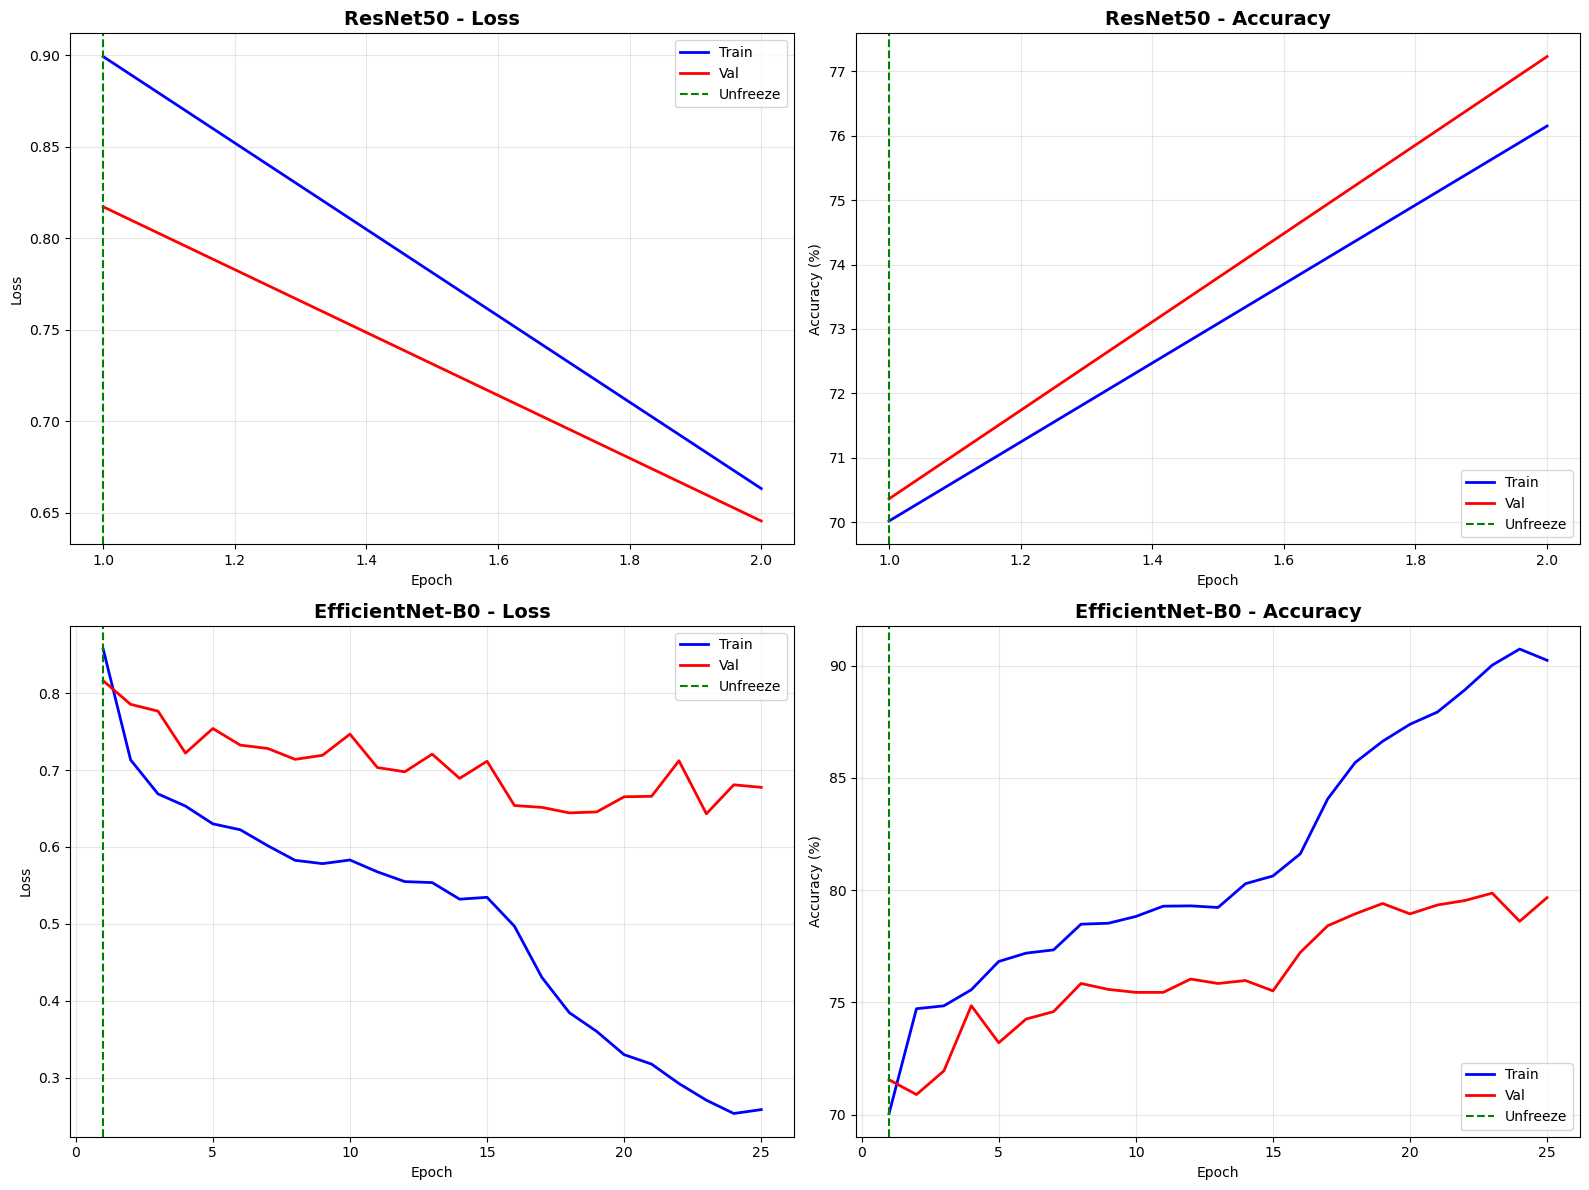

 Training curves saved


In [7]:
import json
import matplotlib.pyplot as plt

# 1. Load the history files you saved earlier
with open('../trained_model_file/resnet_baseline_running.json', 'r') as f:
    resnet_history = json.load(f)

with open('../trained_model_file/effnet_baseline_running.json', 'r') as f:
    effnet_history = json.load(f)

# 2. Re-define the Phase 1 constant for the vertical lines
NUM_EPOCHS_PHASE1 = 1  # Set this to the value you used in training (e.g., 10)

# --- NOW your plotting code will work ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

epochs_resnet = range(1, len(resnet_history['train_loss']) + 1)
epochs_effnet = range(1, len(effnet_history['train_loss']) + 1)

# ResNet Loss
axes[0, 0].plot(epochs_resnet, resnet_history['train_loss'], 'b-', label='Train', linewidth=2)
axes[0, 0].plot(epochs_resnet, resnet_history['val_loss'], 'r-', label='Val', linewidth=2)
axes[0, 0].axvline(x=NUM_EPOCHS_PHASE1, color='green', linestyle='--', label='Unfreeze')
axes[0, 0].set_title('ResNet50 - Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# ResNet Accuracy
axes[0, 1].plot(epochs_resnet, resnet_history['train_acc'], 'b-', label='Train', linewidth=2)
axes[0, 1].plot(epochs_resnet, resnet_history['val_acc'], 'r-', label='Val', linewidth=2)
axes[0, 1].axvline(x=NUM_EPOCHS_PHASE1, color='green', linestyle='--', label='Unfreeze')
axes[0, 1].set_title('ResNet50 - Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# EfficientNet Loss
axes[1, 0].plot(epochs_effnet, effnet_history['train_loss'], 'b-', label='Train', linewidth=2)
axes[1, 0].plot(epochs_effnet, effnet_history['val_loss'], 'r-', label='Val', linewidth=2)
axes[1, 0].axvline(x=NUM_EPOCHS_PHASE1, color='green', linestyle='--', label='Unfreeze')
axes[1, 0].set_title('EfficientNet-B0 - Loss', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# EfficientNet Accuracy
axes[1, 1].plot(epochs_effnet, effnet_history['train_acc'], 'b-', label='Train', linewidth=2)
axes[1, 1].plot(epochs_effnet, effnet_history['val_acc'], 'r-', label='Val', linewidth=2)
axes[1, 1].axvline(x=NUM_EPOCHS_PHASE1, color='green', linestyle='--', label='Unfreeze')
axes[1, 1].set_title('EfficientNet-B0 - Accuracy', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(" Training curves saved")

## 8. Evaluate Both Models on Test Set

## 9. Confusion Matrices Comparison

 Caching image paths to optimize speed...


Mapping Files:   0%|          | 0/1519 [00:00<?, ?it/s]


 Evaluating ResNet50...


Evaluating:   0%|          | 0/48 [00:03<?, ?it/s]


 Evaluating EfficientNet-B0...


Evaluating:   0%|          | 0/48 [00:03<?, ?it/s]


ResNet50 Acc:    73.34%
EffNet-B0 Acc:   75.58%

 Generating Confusion Matrices...


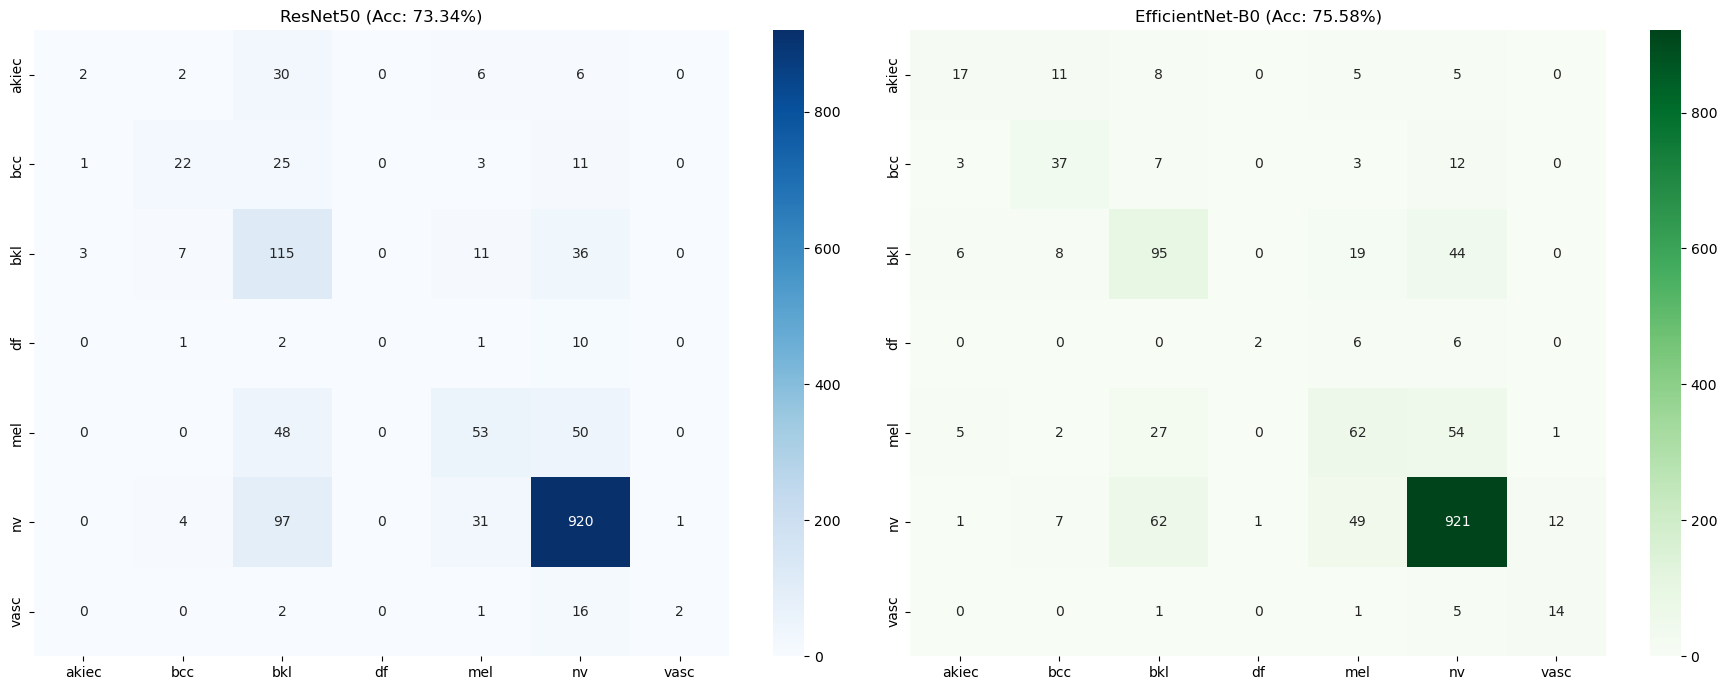

In [11]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
from torchvision import transforms, models
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms, models
from tqdm.auto import tqdm
import os
from my_data_utils import SkinLesionDataset

# --- 1. CONFIGURATION ---
IMG_SIZE = 224
BATCH_SIZE = 32
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
num_classes = len(classes)

# --- 2. ARCHITECTURES ---
def get_resnet50(num_classes):
    model = models.resnet50()
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5), nn.Linear(num_features, 512),
        nn.ReLU(), nn.Dropout(0.3), nn.Linear(512, num_classes)
    )
    return model

def get_effnet(num_classes):
    model = models.efficientnet_b0()
    num_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.4, inplace=True), nn.Linear(num_features, 512),
        nn.ReLU(), nn.Dropout(p=0.3), nn.Linear(512, num_classes)
    )
    return model

# --- 3. EVALUATION FUNCTION ---
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Evaluating', leave=False):
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    acc = 100. * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    return acc, all_preds, all_labels

# --- 4. MAIN EXECUTION ---
if __name__ == '__main__':
    # Setup Data
    test_df = pd.read_csv('/Users/sujanbhattarai/deep_learning/data/data/test_split.csv')
    data_dir = '/Users/sujanbhattarai/deep_learning/data/ham10000/'
    
    test_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    test_dataset = SkinLesionDataset(test_df, data_dir, transform=test_transform)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4)

    # --- EVALUATE RESNET50 ---
    print("\n Evaluating ResNet50...")
    resnet_model = get_resnet50(num_classes).to(device)
    resnet_model.load_state_dict(torch.load('../trained_model_file/resnet50_best.pth', map_location=device))
    resnet_acc, resnet_preds, resnet_labels = evaluate_model(resnet_model, test_loader, device)

    # --- EVALUATE EFFICIENTNET ---
    print("\n Evaluating EfficientNet-B0...")
    effnet_model = get_effnet(num_classes).to(device)
    effnet_model.load_state_dict(torch.load('../trained_model_file/effnet_b0_best.pth', map_location=device))
    effnet_acc, effnet_preds, effnet_labels = evaluate_model(effnet_model, test_loader, device)

    # --- FINAL SUMMARY PRINT ---
    print("\n" + "="*30)
    print(f"ResNet50 Acc:    {resnet_acc:.2f}%")
    print(f"EffNet-B0 Acc:   {effnet_acc:.2f}%")
    print("="*30)

    # --- PLOTTING ---
    print("\n Generating Confusion Matrices...")
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))

    # ResNet50 Heatmap
    cm_res = confusion_matrix(resnet_labels, resnet_preds)
    sns.heatmap(cm_res, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=classes, yticklabels=classes)
    axes[0].set_title(f'ResNet50 (Acc: {resnet_acc:.2f}%)')

    # EffNet Heatmap
    cm_eff = confusion_matrix(effnet_labels, effnet_preds)
    sns.heatmap(cm_eff, annot=True, fmt='d', cmap='Greens', ax=axes[1],
                xticklabels=classes, yticklabels=classes)
    axes[1].set_title(f'EfficientNet-B0 (Acc: {effnet_acc:.2f}%)')

    plt.tight_layout()
    plt.show()

/Users/sujanbhattarai/deep_learning/notebooks


## 10. Classification Reports

In [ ]:
class_names_list = [idx_to_class[i] for i in range(num_classes)]

# ResNet50 Report
print("="*70)
print("RESNET50 CLASSIFICATION REPORT")
print("="*70)
resnet_report = classification_report(resnet_labels, resnet_preds, 
                                      target_names=class_names_list, digits=4)
print(resnet_report)

# EfficientNet Report
print("\n" + "="*70)
print("EFFICIENTNET-B0 CLASSIFICATION REPORT")
print("="*70)
effnet_report = classification_report(effnet_labels, effnet_preds, 
                                      target_names=class_names_list, digits=4)
print(effnet_report)

# Save reports
with open('results/resnet50_classification_report.txt', 'w') as f:
    f.write("RESNET50 CLASSIFICATION REPORT\n")
    f.write("="*70 + "\n")
    f.write(resnet_report)

with open('results/efficientnet_b0_classification_report.txt', 'w') as f:
    f.write("EFFICIENTNET-B0 CLASSIFICATION REPORT\n")
    f.write("="*70 + "\n")
    f.write(effnet_report)

print("\n Classification reports saved")

RESNET50 CLASSIFICATION REPORT
              precision    recall  f1-score   support

       akiec     0.4286    0.1957    0.2687        46
         bcc     0.4792    0.3710    0.4182        62
         bkl     0.4191    0.6628    0.5135       172
          df     0.0000    0.0000    0.0000        14
         mel     0.4028    0.3841    0.3932       151
          nv     0.8847    0.8528    0.8685      1053
        vasc     0.5789    0.5238    0.5500        21

    accuracy                         0.7327      1519
   macro avg     0.4562    0.4272    0.4303      1519
weighted avg     0.7413    0.7327    0.7321      1519


EFFICIENTNET-B0 CLASSIFICATION REPORT
              precision    recall  f1-score   support

       akiec     0.5556    0.5435    0.5495        46
         bcc     0.6515    0.6935    0.6719        62
         bkl     0.5202    0.5988    0.5568       172
          df     0.0000    0.0000    0.0000        14
         mel     0.4907    0.3510    0.4093       151
        

## 11. Per-Class Performance Comparison


PER-CLASS PERFORMANCE COMPARISON
Class  ResNet50_Precision  EfficientNet_Precision  ResNet50_Recall  EfficientNet_Recall  ResNet50_F1  EfficientNet_F1
akiec            0.428571                0.555556         0.195652             0.543478     0.268657         0.549451
  bcc            0.479167                0.651515         0.370968             0.693548     0.418182         0.671875
  bkl            0.419118                0.520202         0.662791             0.598837     0.513514         0.556757
   df            0.000000                0.000000         0.000000             0.000000     0.000000         0.000000
  mel            0.402778                0.490741         0.384106             0.350993     0.393220         0.409266
   nv            0.884729                0.877645         0.852802             0.905983     0.868472         0.891589
 vasc            0.578947                0.866667         0.523810             0.619048     0.550000         0.722222


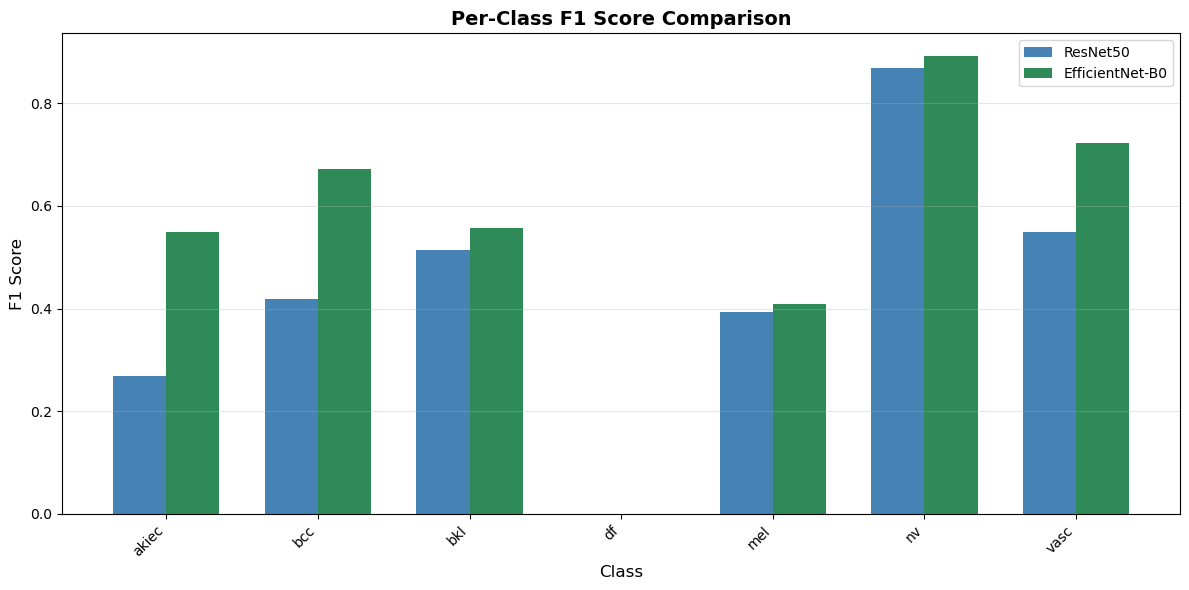


✅ Comparison saved


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Get per-class metrics
resnet_metrics = precision_recall_fscore_support(resnet_labels, resnet_preds, average=None)
effnet_metrics = precision_recall_fscore_support(effnet_labels, effnet_preds, average=None)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Class': class_names_list,
    'ResNet50_Precision': resnet_metrics[0],
    'EfficientNet_Precision': effnet_metrics[0],
    'ResNet50_Recall': resnet_metrics[1],
    'EfficientNet_Recall': effnet_metrics[1],
    'ResNet50_F1': resnet_metrics[2],
    'EfficientNet_F1': effnet_metrics[2]
})

print("\n" + "="*70)
print("PER-CLASS PERFORMANCE COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Visualize F1 scores comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(class_names_list))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['ResNet50_F1'], width, label='ResNet50', color='steelblue')
bars2 = ax.bar(x + width/2, comparison_df['EfficientNet_F1'], width, label='EfficientNet-B0', color='seagreen')

ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('F1 Score', fontsize=12)
ax.set_title('Per-Class F1 Score Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names_list, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('results/per_class_f1_comparison.png', dpi=300, bbox_inches='tight')
plt.show()